# 43008: Reinforcement Learning

## Week 6: Monte Carlo Methods - Control:
* MC Algorithm for finding optimal policy - Model free approach

### What you will learn?
* MC Algorithm for finding optimal policy for Gym based environments

### Import Libraries

In [2]:
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 944.3/944.3 kB 53.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [gymnasium]/2 [gymnasium]


In [3]:
import gymnasium as gym
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import sys

### Helper function for visualisation

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def plot_blackjack_values(Q):
    """
    Given a Q-table, this function plots the state-value function for Blackjack,
    aligning with the representation in Sutton and Barto's book.

    Args:
    - Q (dict): The Q-table.
    """

    V = {}  # For storing the state-value function

    # Populate the V dictionary with state-value pairs
    for k, v in Q.items():
        # Check if v is a dictionary (i.e., nested dictionary structure)
        if isinstance(v, dict):
            values = list(v.values())
        else:
            values = v

        # If the values list has only one entry, pad it with zero to make it a two-element list
        if len(values) == 1:
            values.append(0.0)

        # Compute the state-value based on a policy:
        # If player's current sum is greater than 18, the policy is 80% stick and 20% hit.
        # Otherwise, the policy is 20% stick and 80% hit.
        if k[0] > 18:
            V[k] = np.dot([0.8, 0.2], values)
        else:
            V[k] = np.dot([0.2, 0.8], values)

    # Helper function to get Z values for plotting
    def get_Z(x, y, usable_ace):
        # Return the state value if the state exists in V, otherwise return 0
        if (x, y, usable_ace) in V:
            return V[(x, y, usable_ace)]
        else:
            return 0

    # Helper function to generate the 3D surface plot for a given usable ace condition
    def get_figure(usable_ace, ax):
        # Define the range for player's sum and dealer's card
        x_range = np.arange(12, 22)  # Player's sum: 12 through 21
        y_range = np.arange(10, 0, -1)  # Dealer's card: 10 through Ace

        # Create a meshgrid for plotting
        X, Y = np.meshgrid(x_range, y_range)

        # Calculate Z values using the get_Z function
        Z = np.array([get_Z(x, y, usable_ace) for x, y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        # Plot the surface with the provided colormap
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)

        # Label the axes
        ax.set_xlabel("Player's Current Sum")
        ax.set_ylabel("Dealer's Showing Card")
        ax.set_yticks(np.arange(1, 11))
        ax.set_yticklabels(['10', '9', '8', '7', '6', '5', '4', '3', '2', 'A'])  # Reverse order for y-axis labels
        ax.set_zlabel('State Value')

        # Set the viewing angle to give the desired orientation
        ax.view_init(ax.elev, -120)

    # Create the 3D plot
    fig = plt.figure(figsize=(20, 20))

    # Plot for the case with a usable ace
    ax = fig.add_subplot(211, projection='3d')
    ax.set_title('Usable Ace')
    get_figure(True, ax)

    # Plot for the case without a usable ace
    ax = fig.add_subplot(212, projection='3d')
    ax.set_title('No Usable Ace')
    get_figure(False, ax)

    # Display the plots
    plt.show()


In [5]:
def plot_blackjack_policy_from_Q(Q):
    """
    Plot the Blackjack policy derived from Q values.

    Args:
    - Q (dict): The Q-table, mapping states to action-value pairs.
    """

    # Define the range for dealer's card and player's sum
    x_range = np.arange(1, 11)  # Dealer's card: Ace through 10
    y_range = np.arange(12, 22)  # Player's sum: 12 through 21

    # Create two 2D matrices to store policy data for usable and non-usable ace scenarios.
    policy_data_usable = np.zeros((len(y_range), len(x_range)))
    policy_data_non_usable = np.zeros((len(y_range), len(x_range)))

    # Derive policy from Q values
    for state, actions in Q.items():
        player_sum, dealer_card, usable_ace = state
        # Get the action with the maximum Q value
        best_action = np.argmax(actions)
        if usable_ace:
            policy_data_usable[player_sum - 12, dealer_card - 1] = best_action
        else:
            policy_data_non_usable[player_sum - 12, dealer_card - 1] = best_action

    fig, axes = plt.subplots(nrows=2, figsize=(10, 20))

    # Plot the policy for states with a usable ace
    axes[0].matshow(policy_data_usable, cmap=plt.cm.coolwarm, extent=[0.5, 10.5, 21.5, 11.5])
    axes[0].set_title('Usable Ace')
    axes[0].invert_yaxis()  # Invert the y-axis

    # Plot the policy for states without a usable ace
    axes[1].matshow(policy_data_non_usable, cmap=plt.cm.coolwarm, extent=[0.5, 10.5, 21.5, 11.5])
    axes[1].set_title('No Usable Ace')
    axes[1].invert_yaxis()  # Invert the y-axis

    for ax in axes:
        ax.set_xticks(np.arange(1, 11))
        ax.set_yticks(np.arange(12, 22))
        ax.set_yticklabels(list(range(12, 22)))  # Corrected player sums labels
        ax.set_xlabel("Dealer's Showing Card")
        ax.set_ylabel("Player's Current Sum")

    plt.tight_layout()
    plt.show()


## GLIE MC-Control Algorithm


<img src='https://drive.google.com/uc?id=1kY0AdRSrCyZHRyWEo0wnjmLoAj9qCU9W' height=400>


##**Steps**:

1.   Write a function for Implementing Epsilon-Greedy Policy
2.   Write a function for creating Episodes
3.   Write a function for Updating Q-Values
4.   Combine all the functions to complete the GLIE Control Algorithm



### 1. Implement Epsilon Greedy Policy

In [11]:
def epsilon_greedy_policy(state, Q, epsilon):
    """Select an action using epsilon-greedy policy."""
    state = tuple(state)
    if state not in Q:
        Q[state] = [0, 0]

    # Randomly choose an action with probability epsilon (Exploration)
    if np.random.rand() < epsilon:
        return env.action_space.sample()
    # Choose the action with the highest Q-value for the current state (Exploitation)
    else:
        return np.argmax(Q[state])

### 2. Implement Generate Episode function

In [16]:
# Generate Episode function
def generate_episode(env, Q, epsilon):
    """Generate an episode following the epsilon-greedy policy."""
    episode = []
    # Reset environment to starting state
    state_tuple, info = env.reset() # env.reset() returns a tuple (observation, info)
    state = state_tuple # Access the state directly from the tuple
    done = False

    # Continue until the episode is done
    while not done:
        # Select an action based on epsilon-greedy policy
        action = epsilon_greedy_policy(state, Q, epsilon)
        # Take the action and observe the next state and reward
        next_state_tuple, reward, done, truncated, info = env.step(action) # env.step() returns a tuple (observation, reward, done, truncated, info)
        next_state = next_state_tuple # Access the next state directly from the tuple
        # Append the state, action, and reward to the episode list
        episode.append((state, action, reward))
        state = next_state

    return episode

### 3. Implement Q-Value Update

In [17]:
def update_Q_values(episode, Q, N, gamma):
    """Update Q-values using the generated episode."""
    # Initialize the return (G_t) to zero
    G_t = 0
    # Iterate over the episode in reverse order
    for state, action, reward in reversed(episode):
        # Ensure the state is initialized in Q and N
        if state not in Q:
            Q[state] = [0, 0]
        if state not in N:
            N[state] = [0, 0]

        # Calculate the cumulative discounted reward
        G_t = gamma * G_t + reward
        # Increment the count for the state-action pair
        N[state][action] += 1
        # Calculate the step-size (alpha)
        alpha = 1 / N[state][action]
        # Incrementally update the Q-value using the return (G_t)
        Q[state][action] += alpha * (G_t - Q[state][action])

### 4. Implement GLIE MC Control

In [18]:
def glie_mc_control(env, episodes, gamma, epsilon, decay):
    """Train the agent using GILE MC Control."""
    # Initialize Q-values with zeros for each state-action pair
    Q = {}
    # Initialize N (counts) with zeros for each state-action pair
    N = {}
    # Iterate over the specified number of episodes
    for k in range(1, episodes + 1):
        # Generate an episode
        episode = generate_episode(env, Q, epsilon)
        print(f"Episode {k}/{episodes}, Current epsilon: {epsilon}")
        sys.stdout.flush()
        # Update Q-values using the episode
        update_Q_values(episode, Q, N, gamma)
        # Decay epsilon to reduce exploration over time
        epsilon *= decay

    # After all episodes are processed, derive the policy from the Q-values.
    policy = {}
    for state, actions in Q.items():
        policy[state] = np.argmax(actions)
    print(f"Derived policy for {len(policy)} states.")  # Debug: Print the number of states for which policy is derived
    return Q, policy

### 5. Solve the BlackJack environment using the GLIE MC Control Algorithm

In [19]:
# Create the Blackjack environment
env = gym.make('Blackjack-v1', natural=False, sab=True)

# Set hyperparameters
gamma = 0.9  # Discount factor
epsilon = 1.0  # Initial exploration factor
decay = 0.9995  # Decay rate for epsilon
episodes = 50000  # Number of training episodes

# Train the agent
Q, policy = glie_mc_control(env, episodes, gamma, epsilon, decay)

# Close the environment
env.close()


Episode 1/50000, Current epsilon: 1.0
Episode 2/50000, Current epsilon: 0.9995
Episode 3/50000, Current epsilon: 0.9990002500000001
Episode 4/50000, Current epsilon: 0.9985007498750001
Episode 5/50000, Current epsilon: 0.9980014995000627
Episode 6/50000, Current epsilon: 0.9975024987503127
Episode 7/50000, Current epsilon: 0.9970037475009376
Episode 8/50000, Current epsilon: 0.9965052456271871
Episode 9/50000, Current epsilon: 0.9960069930043736
Episode 10/50000, Current epsilon: 0.9955089895078715
Episode 11/50000, Current epsilon: 0.9950112350131176
Episode 12/50000, Current epsilon: 0.9945137293956111
Episode 13/50000, Current epsilon: 0.9940164725309134
Episode 14/50000, Current epsilon: 0.993519464294648
Episode 15/50000, Current epsilon: 0.9930227045625007
Episode 16/50000, Current epsilon: 0.9925261932102195
Episode 17/50000, Current epsilon: 0.9920299301136144
Episode 18/50000, Current epsilon: 0.9915339151485576
Episode 19/50000, Current epsilon: 0.9910381481909833
Episode 20/

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Episode 4421/50000, Current epsilon: 0.10964003544793775
Episode 4422/50000, Current epsilon: 0.1095852154302138
Episode 4423/50000, Current epsilon: 0.1095304228224987
Episode 4424/50000, Current epsilon: 0.10947565761108745
Episode 4425/50000, Current epsilon: 0.10942091978228191
Episode 4426/50000, Current epsilon: 0.10936620932239077
Episode 4427/50000, Current epsilon: 0.10931152621772958
Episode 4428/50000, Current epsilon: 0.10925687045462072
Episode 4429/50000, Current epsilon: 0.10920224201939342
Episode 4430/50000, Current epsilon: 0.10914764089838373
Episode 4431/50000, Current epsilon: 0.10909306707793455
Episode 4432/50000, Current epsilon: 0.10903852054439558
Episode 4433/50000, Current epsilon: 0.10898400128412339
Episode 4434/50000, Current epsilon: 0.10892950928348133
Episode 4435/50000, Current epsilon: 0.1088750445288396
Episode 4436/50000, Current epsilon: 0.10882060700657518
Episode 4437/50000, Current epsilon: 0.1087661967030719
Episode 4438/50000, Current epsilon

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Episode 8735/50000, Current epsilon: 0.012675400732190954
Episode 8736/50000, Current epsilon: 0.012669063031824858
Episode 8737/50000, Current epsilon: 0.012662728500308947
Episode 8738/50000, Current epsilon: 0.012656397136058792
Episode 8739/50000, Current epsilon: 0.012650068937490764
Episode 8740/50000, Current epsilon: 0.012643743903022019
Episode 8741/50000, Current epsilon: 0.012637422031070508
Episode 8742/50000, Current epsilon: 0.012631103320054973
Episode 8743/50000, Current epsilon: 0.012624787768394947
Episode 8744/50000, Current epsilon: 0.01261847537451075
Episode 8745/50000, Current epsilon: 0.012612166136823495
Episode 8746/50000, Current epsilon: 0.012605860053755084
Episode 8747/50000, Current epsilon: 0.012599557123728207
Episode 8748/50000, Current epsilon: 0.012593257345166343
Episode 8749/50000, Current epsilon: 0.012586960716493761
Episode 8750/50000, Current epsilon: 0.012580667236135516
Episode 8751/50000, Current epsilon: 0.01257437690251745
Episode 8752/500

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Episode 13073/50000, Current epsilon: 0.0014479094161682648
Episode 13074/50000, Current epsilon: 0.0014471854614601808
Episode 13075/50000, Current epsilon: 0.0014464618687294508
Episode 13076/50000, Current epsilon: 0.001445738637795086
Episode 13077/50000, Current epsilon: 0.0014450157684761885
Episode 13078/50000, Current epsilon: 0.0014442932605919505
Episode 13079/50000, Current epsilon: 0.0014435711139616546
Episode 13080/50000, Current epsilon: 0.0014428493284046739
Episode 13081/50000, Current epsilon: 0.0014421279037404716
Episode 13082/50000, Current epsilon: 0.0014414068397886014
Episode 13083/50000, Current epsilon: 0.0014406861363687072
Episode 13084/50000, Current epsilon: 0.0014399657933005228
Episode 13085/50000, Current epsilon: 0.0014392458104038727
Episode 13086/50000, Current epsilon: 0.0014385261874986708
Episode 13087/50000, Current epsilon: 0.0014378069244049216
Episode 13088/50000, Current epsilon: 0.0014370880209427191
Episode 13089/50000, Current epsilon: 0.0

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Episode 17408/50000, Current epsilon: 0.0001656428488211579
Episode 17409/50000, Current epsilon: 0.0001655600273967473
Episode 17410/50000, Current epsilon: 0.00016547724738304894
Episode 17411/50000, Current epsilon: 0.00016539450875935742
Episode 17412/50000, Current epsilon: 0.00016531181150497776
Episode 17413/50000, Current epsilon: 0.0001652291555992253
Episode 17414/50000, Current epsilon: 0.00016514654102142568
Episode 17415/50000, Current epsilon: 0.00016506396775091498
Episode 17416/50000, Current epsilon: 0.00016498143576703953
Episode 17417/50000, Current epsilon: 0.00016489894504915603
Episode 17418/50000, Current epsilon: 0.00016481649557663146
Episode 17419/50000, Current epsilon: 0.00016473408732884317
Episode 17420/50000, Current epsilon: 0.00016465172028517876
Episode 17421/50000, Current epsilon: 0.0001645693944250362
Episode 17422/50000, Current epsilon: 0.00016448710972782367
Episode 17423/50000, Current epsilon: 0.00016440486617295977
Episode 17424/50000, Current

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Episode 21727/50000, Current epsilon: 1.9102016442307908e-05
Episode 21728/50000, Current epsilon: 1.9092465434086755e-05
Episode 21729/50000, Current epsilon: 1.908291920136971e-05
Episode 21730/50000, Current epsilon: 1.907337774176903e-05
Episode 21731/50000, Current epsilon: 1.9063841052898144e-05
Episode 21732/50000, Current epsilon: 1.9054309132371696e-05
Episode 21733/50000, Current epsilon: 1.9044781977805513e-05
Episode 21734/50000, Current epsilon: 1.903525958681661e-05
Episode 21735/50000, Current epsilon: 1.9025741957023203e-05
Episode 21736/50000, Current epsilon: 1.9016229086044692e-05
Episode 21737/50000, Current epsilon: 1.900672097150167e-05
Episode 21738/50000, Current epsilon: 1.8997217611015922e-05
Episode 21739/50000, Current epsilon: 1.8987719002210414e-05
Episode 21740/50000, Current epsilon: 1.897822514270931e-05
Episode 21741/50000, Current epsilon: 1.8968736030137956e-05
Episode 21742/50000, Current epsilon: 1.895925166212289e-05
Episode 21743/50000, Current e

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Episode 26056/50000, Current epsilon: 2.1918645996241084e-06
Episode 26057/50000, Current epsilon: 2.1907686673242965e-06
Episode 26058/50000, Current epsilon: 2.1896732829906345e-06
Episode 26059/50000, Current epsilon: 2.1885784463491394e-06
Episode 26060/50000, Current epsilon: 2.187484157125965e-06
Episode 26061/50000, Current epsilon: 2.186390415047402e-06
Episode 26062/50000, Current epsilon: 2.1852972198398783e-06
Episode 26063/50000, Current epsilon: 2.1842045712299584e-06
Episode 26064/50000, Current epsilon: 2.1831124689443437e-06
Episode 26065/50000, Current epsilon: 2.1820209127098717e-06
Episode 26066/50000, Current epsilon: 2.180929902253517e-06
Episode 26067/50000, Current epsilon: 2.1798394373023904e-06
Episode 26068/50000, Current epsilon: 2.1787495175837395e-06
Episode 26069/50000, Current epsilon: 2.177660142824948e-06
Episode 26070/50000, Current epsilon: 2.1765713127535355e-06
Episode 26071/50000, Current epsilon: 2.175483027097159e-06
Episode 26072/50000, Current 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Episode 30365/50000, Current epsilon: 2.540342425971881e-07
Episode 30366/50000, Current epsilon: 2.539072254758895e-07
Episode 30367/50000, Current epsilon: 2.537802718631516e-07
Episode 30368/50000, Current epsilon: 2.5365338172722e-07
Episode 30369/50000, Current epsilon: 2.535265550363564e-07
Episode 30370/50000, Current epsilon: 2.5339979175883825e-07
Episode 30371/50000, Current epsilon: 2.5327309186295884e-07
Episode 30372/50000, Current epsilon: 2.5314645531702735e-07
Episode 30373/50000, Current epsilon: 2.530198820893688e-07
Episode 30374/50000, Current epsilon: 2.5289337214832414e-07
Episode 30375/50000, Current epsilon: 2.5276692546225e-07
Episode 30376/50000, Current epsilon: 2.5264054199951886e-07
Episode 30377/50000, Current epsilon: 2.525142217285191e-07
Episode 30378/50000, Current epsilon: 2.5238796461765486e-07
Episode 30379/50000, Current epsilon: 2.5226177063534605e-07
Episode 30380/50000, Current epsilon: 2.521356397500284e-07
Episode 30381/50000, Current epsilon:

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Episode 34694/50000, Current epsilon: 2.9149208677669022e-08
Episode 34695/50000, Current epsilon: 2.9134634073330188e-08
Episode 34696/50000, Current epsilon: 2.9120066756293524e-08
Episode 34697/50000, Current epsilon: 2.9105506722915377e-08
Episode 34698/50000, Current epsilon: 2.909095396955392e-08
Episode 34699/50000, Current epsilon: 2.9076408492569147e-08
Episode 34700/50000, Current epsilon: 2.9061870288322862e-08
Episode 34701/50000, Current epsilon: 2.9047339353178703e-08
Episode 34702/50000, Current epsilon: 2.9032815683502116e-08
Episode 34703/50000, Current epsilon: 2.9018299275660366e-08
Episode 34704/50000, Current epsilon: 2.9003790126022537e-08
Episode 34705/50000, Current epsilon: 2.8989288230959526e-08
Episode 34706/50000, Current epsilon: 2.8974793586844046e-08
Episode 34707/50000, Current epsilon: 2.8960306190050626e-08
Episode 34708/50000, Current epsilon: 2.89458260369556e-08
Episode 34709/50000, Current epsilon: 2.8931353123937126e-08
Episode 34710/50000, Curren

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Episode 39034/50000, Current epsilon: 3.3263815280258882e-09
Episode 39035/50000, Current epsilon: 3.3247183372618755e-09
Episode 39036/50000, Current epsilon: 3.3230559780932446e-09
Episode 39037/50000, Current epsilon: 3.3213944501041983e-09
Episode 39038/50000, Current epsilon: 3.3197337528791465e-09
Episode 39039/50000, Current epsilon: 3.3180738860027072e-09
Episode 39040/50000, Current epsilon: 3.316414849059706e-09
Episode 39041/50000, Current epsilon: 3.3147566416351766e-09
Episode 39042/50000, Current epsilon: 3.3130992633143594e-09
Episode 39043/50000, Current epsilon: 3.3114427136827026e-09
Episode 39044/50000, Current epsilon: 3.3097869923258615e-09
Episode 39045/50000, Current epsilon: 3.3081320988296987e-09
Episode 39046/50000, Current epsilon: 3.306478032780284e-09
Episode 39047/50000, Current epsilon: 3.304824793763894e-09
Episode 39048/50000, Current epsilon: 3.3031723813670125e-09
Episode 39049/50000, Current epsilon: 3.301520795176329e-09
Episode 39050/50000, Current

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Episode 43331/50000, Current epsilon: 3.8784394683353234e-10
Episode 43332/50000, Current epsilon: 3.876500248601156e-10
Episode 43333/50000, Current epsilon: 3.8745619984768555e-10
Episode 43334/50000, Current epsilon: 3.872624717477617e-10
Episode 43335/50000, Current epsilon: 3.8706884051188784e-10
Episode 43336/50000, Current epsilon: 3.868753060916319e-10
Episode 43337/50000, Current epsilon: 3.866818684385861e-10
Episode 43338/50000, Current epsilon: 3.864885275043669e-10
Episode 43339/50000, Current epsilon: 3.862952832406147e-10
Episode 43340/50000, Current epsilon: 3.861021355989944e-10
Episode 43341/50000, Current epsilon: 3.8590908453119495e-10
Episode 43342/50000, Current epsilon: 3.857161299889294e-10
Episode 43343/50000, Current epsilon: 3.8552327192393496e-10
Episode 43344/50000, Current epsilon: 3.85330510287973e-10
Episode 43345/50000, Current epsilon: 3.8513784503282903e-10
Episode 43346/50000, Current epsilon: 3.8494527611031264e-10
Episode 43347/50000, Current epsil

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Episode 47620/50000, Current epsilon: 4.5402481223859344e-11
Episode 47621/50000, Current epsilon: 4.537977998324742e-11
Episode 47622/50000, Current epsilon: 4.53570900932558e-11
Episode 47623/50000, Current epsilon: 4.5334411548209176e-11
Episode 47624/50000, Current epsilon: 4.5311744342435075e-11
Episode 47625/50000, Current epsilon: 4.528908847026386e-11
Episode 47626/50000, Current epsilon: 4.526644392602873e-11
Episode 47627/50000, Current epsilon: 4.524381070406572e-11
Episode 47628/50000, Current epsilon: 4.522118879871369e-11
Episode 47629/50000, Current epsilon: 4.519857820431434e-11
Episode 47630/50000, Current epsilon: 4.517597891521218e-11
Episode 47631/50000, Current epsilon: 4.515339092575458e-11
Episode 47632/50000, Current epsilon: 4.5130814230291705e-11
Episode 47633/50000, Current epsilon: 4.5108248823176564e-11
Episode 47634/50000, Current epsilon: 4.5085694698764976e-11
Episode 47635/50000, Current epsilon: 4.5063151851415596e-11
Episode 47636/50000, Current epsil

#### Check the results: Optimal Policy and Q-Values

In [20]:
print("\nOptimal Policy:", policy)
print("\nOptimal Q-values:\n", Q)


Optimal Policy: {(6, 7, 0): 1, (8, 7, 0): 0, (17, 7, 0): 0, (17, 10, 0): 0, (18, 4, 0): 0, (11, 8, 0): 1, (21, 8, 0): 0, (11, 1, 0): 1, (19, 1, 0): 0, (16, 10, 0): 1, (18, 10, 0): 0, (16, 2, 0): 1, (14, 8, 0): 1, (17, 8, 0): 0, (13, 5, 1): 1, (16, 4, 0): 0, (17, 2, 0): 0, (12, 10, 0): 1, (9, 9, 0): 1, (12, 5, 1): 1, (5, 10, 0): 0, (20, 8, 0): 0, (21, 7, 1): 0, (18, 7, 0): 0, (14, 10, 0): 1, (15, 10, 0): 0, (21, 10, 0): 0, (13, 9, 0): 1, (16, 1, 0): 1, (20, 9, 0): 0, (10, 8, 0): 1, (12, 2, 0): 1, (9, 10, 0): 1, (20, 3, 0): 0, (13, 10, 1): 1, (12, 8, 0): 1, (21, 4, 1): 0, (21, 9, 1): 0, (15, 9, 0): 1, (7, 10, 0): 1, (13, 1, 1): 1, (14, 1, 1): 1, (14, 1, 0): 0, (13, 2, 0): 1, (14, 3, 0): 1, (16, 3, 0): 0, (18, 3, 0): 0, (12, 6, 0): 0, (14, 6, 0): 0, (19, 10, 1): 1, (15, 5, 0): 0, (20, 10, 0): 0, (20, 1, 0): 0, (21, 1, 0): 0, (20, 5, 0): 0, (4, 9, 0): 1, (10, 9, 0): 1, (17, 9, 1): 1, (17, 9, 0): 0, (15, 1, 0): 1, (14, 5, 1): 1, (13, 5, 0): 0, (16, 5, 0): 1, (15, 7, 0): 0, (9, 2, 0): 1, (1

#### Plot the graph of optimal Q Values

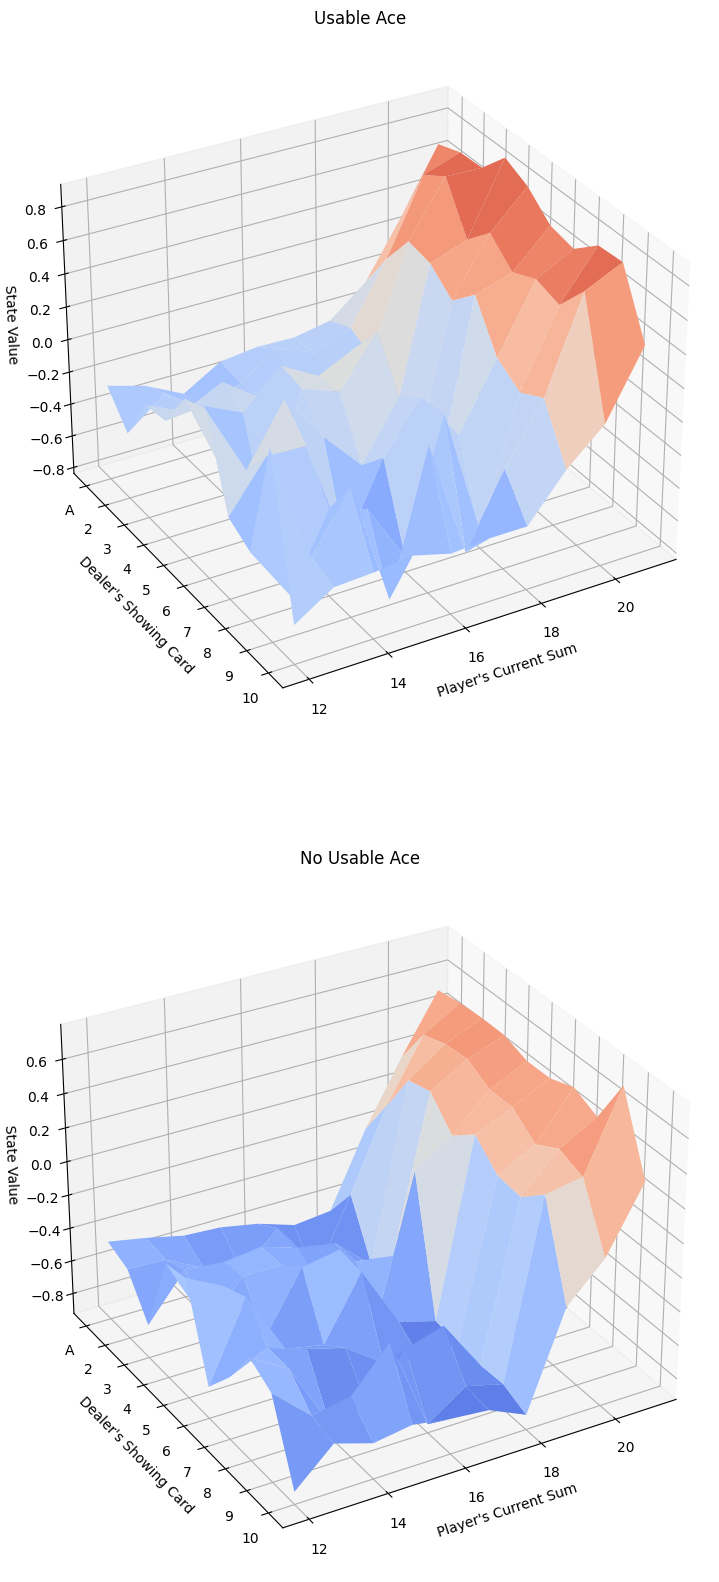

In [16]:
plot_blackjack_values(Q)

#### Plot the graph of optimal Policy

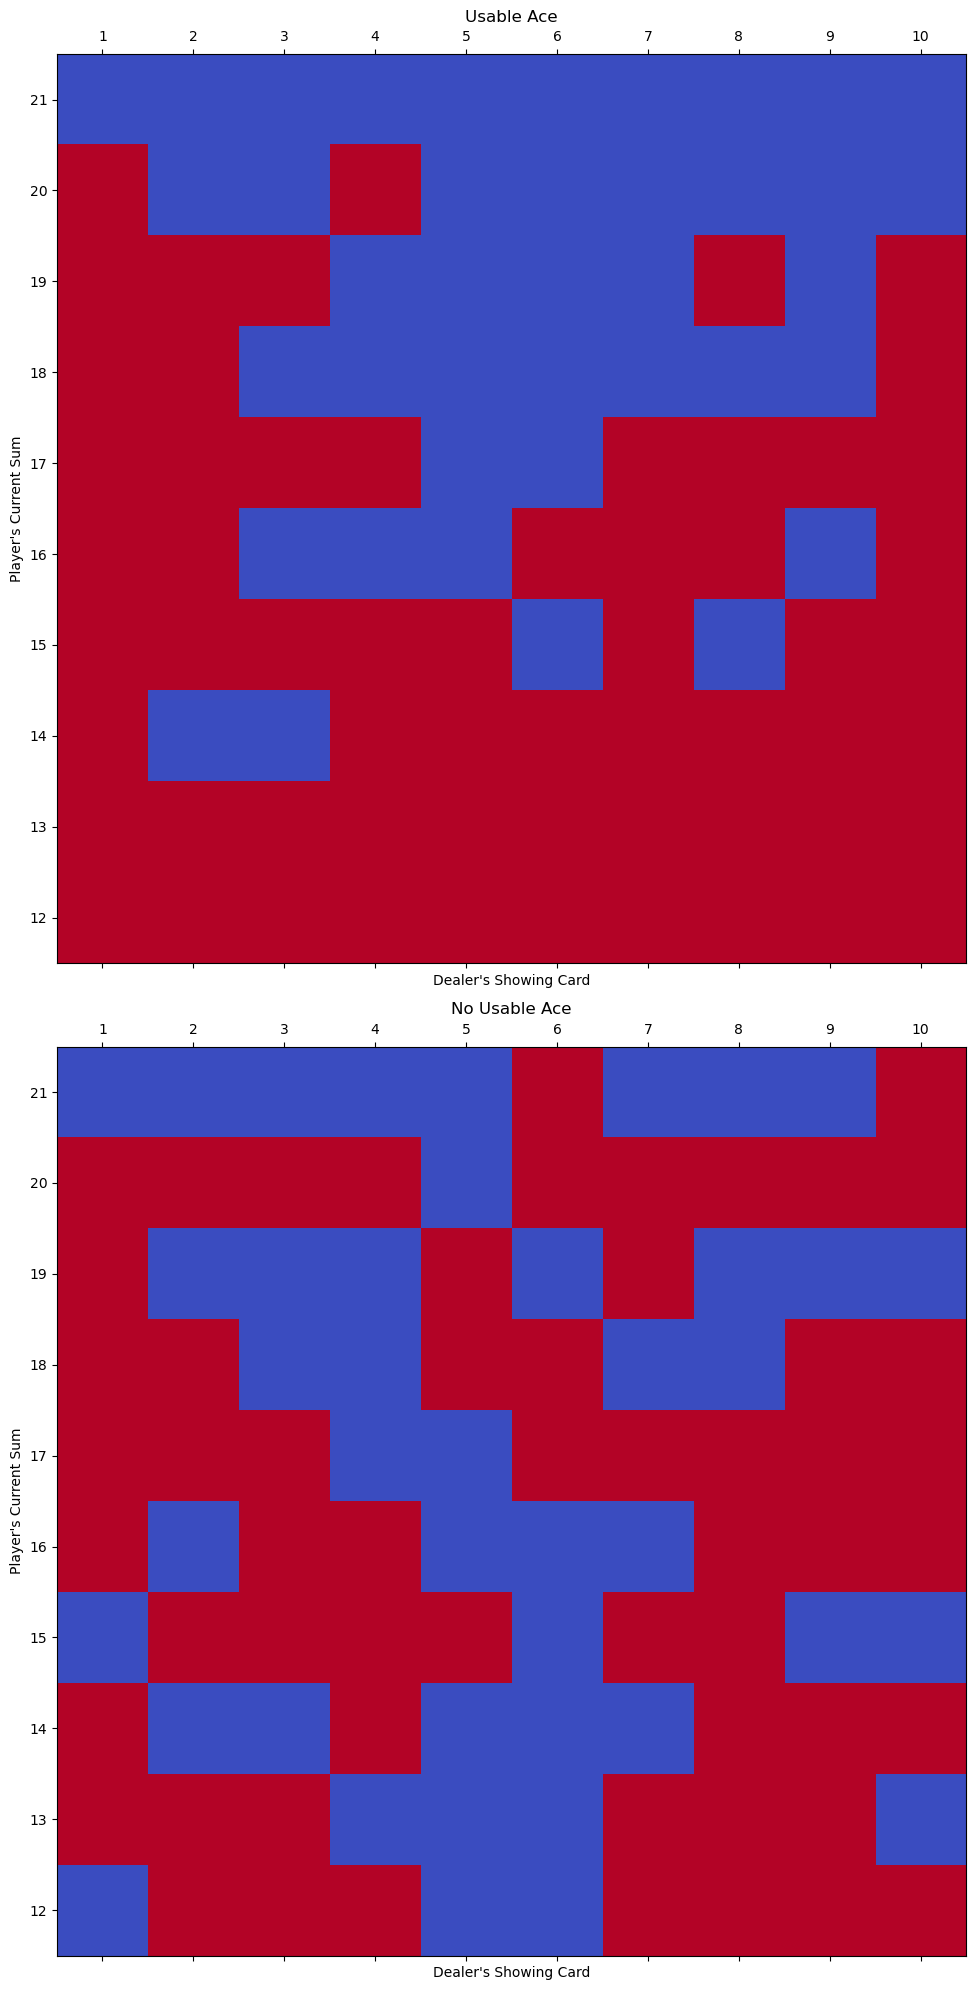

In [22]:
plot_blackjack_policy_from_Q(Q)